In [2]:
import sys
PATH_TO_ROOT='D:/My Repository'
sys.path.insert(0, PATH_TO_ROOT)

In [3]:
import pandas as pd
import numpy as np
from AlphaMobileSensing import Msenseing

In [4]:
datapath='D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/dynamic_50cm_DEMO_new.csv'


env=Msenseing.AlphaMoSeEnv(datapath, 2500, 1, 15, (3.5, 3), 2, (0.5, 0.5), 500)

C:\Users\qizho\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
action_series_df=pd.read_excel('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/action series for test.xlsx')

In [121]:
env.reset()


measurement_log=np.zeros(((len(action_series_df)+1),4))
measurement_log[0,:]=env.obs[:]

for i in range(len(action_series_df)):
    env.step(action_series_df.iloc[i,:].values)
    measurement_log[i+1,:]=env.obs[:]

Episode: 3
Total moving distance (m)
204.0
Total moving time (s)
1390.0


In [9]:
from loess import loess_1d
from sklearn import linear_model
import matplotlib.pyplot as plt

In [192]:
x=measurement_log[0:41,0]
y=measurement_log[0:41,1]

t=measurement_log[0:43, 2]
v=measurement_log[0:43, 3]

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=t)

In [193]:
r_i=v-fglobal[1]

In [194]:
r_i

array([ 1.75066992,  0.0363743 ,  0.25288971,  0.21116916,  0.20733578,
       -0.16529704, -0.18132906, -0.18410037, -0.35843187, -0.12760394,
       -0.15060616, -0.12799905, -0.09337238, -0.1532394 , -0.12451246,
       -0.18882327, -0.4480207 , -0.08024095,  0.12221331, -0.14206057,
        0.31904864,  0.03848576,  0.21118997, -0.03104563,  0.07396052,
        0.02935619,  0.13668808, -0.1341631 ,  0.2231979 , -0.16065436,
       -0.54786108,  0.0784954 , -0.29045911, -0.03763806, -0.21550282,
        0.10143282, -0.133106  , -0.01307745,  0.10332728, -0.06553507,
        0.20798945,  0.0025982 ,  0.0025982 ])

In [266]:
nor_measurement_log=np.zeros((43,3))
for i in range(3):
    nor_measurement_log[:,i]=(measurement_log[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

In [267]:
reg=linear_model.LinearRegression()
reg.fit(nor_measurement_log[:, 0:3], r_i)

LinearRegression()

In [268]:
reg.coef_

array([ 0.72525755, -0.28781809, -0.96649837])

In [269]:
reg.intercept_

0.2292211188263971

In [270]:
target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [271]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

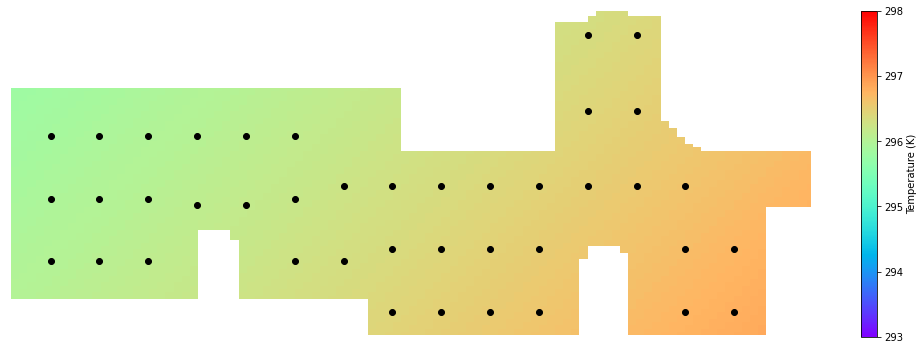

In [272]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=293, vmax=298)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [282]:
reg=linear_model.Ridge(alpha=0.5)
reg.fit(nor_measurement_log[:, 0:3], r_i)

Ridge(alpha=0.5)

In [283]:
reg.coef_

array([-0.08450267, -0.24728199, -0.10710333])

In [284]:
reg.intercept_

0.1936501961329152

In [277]:
target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [278]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

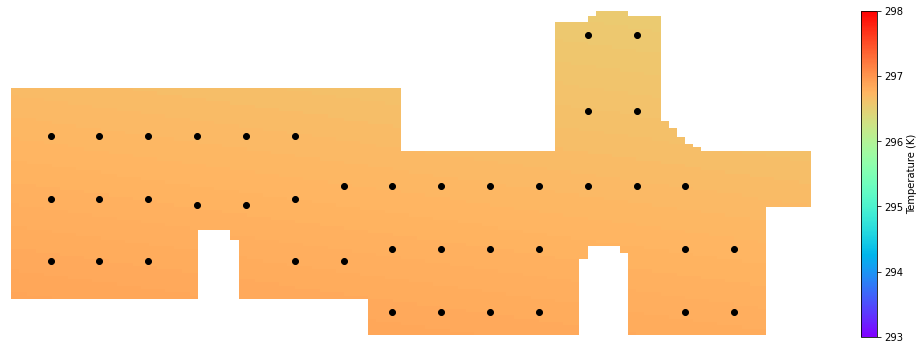

In [286]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=293, vmax=298)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [294]:
reg=linear_model.Lasso(alpha=0.1)
reg.fit(nor_measurement_log[:, 0:3], r_i)
target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=reg.predict(nor_xflat)+fglobal[1]


In [296]:
fglobal[1]

array([296.79375205])

In [298]:
reg.predict(nor_xflat)

array([-0.00106184, -0.00106184, -0.00106184, ..., -0.00106184,
       -0.00106184, -0.00106184])

In [299]:
nor_xflat

array([[-0.06349206, -0.09090909,  0.99750623],
       [-0.06349206, -0.07899449,  0.99750623],
       [-0.06349206, -0.06707989,  0.99750623],
       ...,
       [ 1.11190476,  1.06480716,  0.99750623],
       [ 1.11190476,  1.07672176,  0.99750623],
       [ 1.11190476,  1.08863636,  0.99750623]])

In [300]:
nor_measurement_log[:, 0:3]

array([[0.        , 0.18181818, 0.        ],
       [0.        , 0.40909091, 0.01995012],
       [0.        , 0.63636364, 0.03990025],
       [0.07142857, 0.63636364, 0.06982544],
       [0.07142857, 0.40909091, 0.08977556],
       [0.07142857, 0.18181818, 0.10972569],
       [0.14285714, 0.18181818, 0.13965087],
       [0.14285714, 0.40909091, 0.159601  ],
       [0.14285714, 0.63636364, 0.17955112],
       [0.21428571, 0.63636364, 0.20947631],
       [0.21428571, 0.38636364, 0.24438903],
       [0.28571429, 0.38636364, 0.27431421],
       [0.28571429, 0.63636364, 0.30922693],
       [0.35714286, 0.63636364, 0.33915212],
       [0.35714286, 0.40909091, 0.35910224],
       [0.35714286, 0.18181818, 0.37905237],
       [0.42857143, 0.18181818, 0.40897756],
       [0.42857143, 0.45454545, 0.43142145],
       [0.5       , 0.45454545, 0.46134663],
       [0.5       , 0.22727273, 0.48129676],
       [0.5       , 0.        , 0.50124688],
       [0.57142857, 0.        , 0.53117207],
       [0.

In [289]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

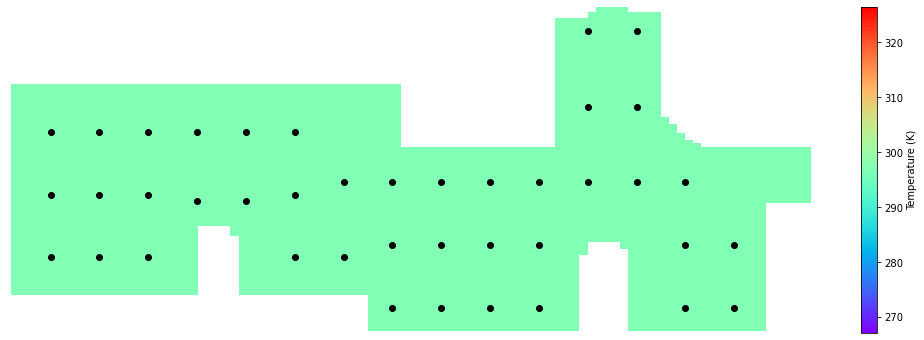

In [293]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow')
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [210]:
from sklearn import svm

In [211]:
regr=svm.SVR()
regr.fit(measurement_log[:, 0:3], r_i)

SVR()

In [212]:
target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=regr.predict(xflat)+fglobal[1]

In [213]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

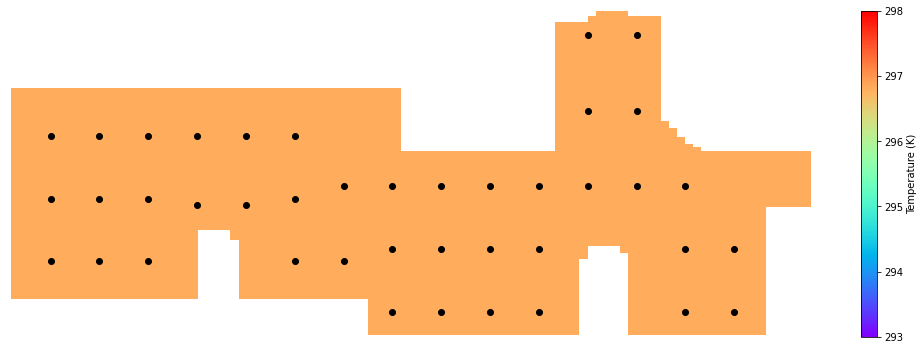

In [214]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=293, vmax=298)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')